In [1]:
import os
import numpy as np
import librosa
import pywt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ----------------------
# Feature Extraction Functions
# ----------------------

def extract_mfcc(y, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

def extract_pitch_swipe(y, sr):
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    avg_pitch = np.mean(pitches[magnitudes > np.median(magnitudes)])
    return np.array([avg_pitch if not np.isnan(avg_pitch) else 0])

def extract_pitch_class_distribution(y, sr):
    pcd = librosa.feature.tonnetz(y=y, sr=sr)
    return np.mean(pcd, axis=1)

def extract_chroma(y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return np.mean(chroma, axis=1)

def extract_dwt(y):
    coeffs = pywt.wavedec(y, 'db1', level=3)
    return np.array([np.mean(c) for c in coeffs])

def extract_cwt(y):
    scales = np.arange(1, 21)
    coefficients, _ = pywt.cwt(y, scales, 'morl')
    return np.mean(coefficients, axis=1)

def extract_features(y, sr):
    return np.hstack([
        extract_mfcc(y, sr),
        extract_pitch_swipe(y, sr),
        extract_pitch_class_distribution(y, sr),
        extract_chroma(y, sr),
        extract_dwt(y),
        extract_cwt(y)
    ])

# ----------------------
# Load Data from "dataset"
# ----------------------

def load_dataset(dataset_path='dataset', sample_rate=22050):
    X, y = [], []
    for raga in os.listdir(dataset_path):
        raga_folder = os.path.join(dataset_path, raga)
        if not os.path.isdir(raga_folder):
            continue
        for filename in os.listdir(raga_folder):
            if filename.endswith('.wav'):
                file_path = os.path.join(raga_folder, filename)
                y_audio, sr = librosa.load(file_path, sr=sample_rate)
                features = extract_features(y_audio, sr)
                X.append(features)
                y.append(raga)
    return np.array(X), np.array(y)

# ----------------------
# LSTM Model Definition
# ----------------------

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ----------------------
# Main Execution
# ----------------------

# Step 1: Load data
X, y = load_dataset('dataset')

# Step 2: Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 3: Reshape features for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 5: Build and train model
model = build_lstm_model(input_shape=(X.shape[1], X.shape[2]), num_classes=len(np.unique(y)))
model.summary()
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

# Step 6: Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        94,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,938 (581.79 KB)

 Trainable params: 148,938 (581.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2207 - loss: 2.1562 - val_accuracy: 0.4089 - val_loss: 1.7263
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4276 - loss: 1.7408 - val_accuracy: 0.5585 - val_loss: 1.3714
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4915 - loss: 1.4862 - val_accuracy: 0.5875 - val_loss: 1.2119
Epoch 4/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5437 - loss: 1.3408 - val_accuracy: 0.6019 - val_loss: 1.0723
Epoch 5/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5757 - loss: 1.1810 - val_accuracy: 0.6972 - val_loss: 0.8852
Epoch 6/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6232 - loss: 1.1053 - val_accuracy: 0.7515 - val_loss: 0.7522
Epoch 7/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6469 - loss: 1.0009 - val_accuracy: 0.7732 - val_loss: 0.7110
Epoch 8/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6750 - loss: 0.9452 - val_accuracy: 0.

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


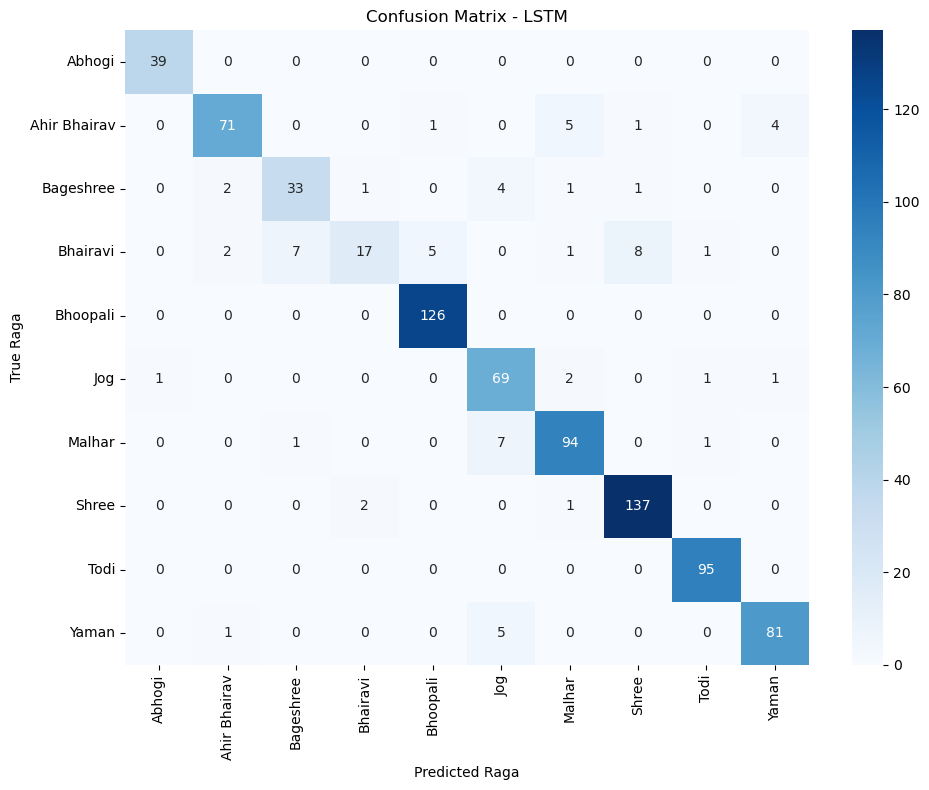


Accuracy: 0.9191797346200241
Precision (macro): 0.9077465898704207
Recall (macro): 0.8820861793578118
F1 Score (macro): 0.886709097244679

Classification Report:
              precision    recall  f1-score   support

      Abhogi       0.97      1.00      0.99        39
Ahir Bhairav       0.93      0.87      0.90        82
   Bageshree       0.80      0.79      0.80        42
    Bhairavi       0.85      0.41      0.56        41
    Bhoopali       0.95      1.00      0.98       126
         Jog       0.81      0.93      0.87        74
      Malhar       0.90      0.91      0.91       103
       Shree       0.93      0.98      0.95       140
        Todi       0.97      1.00      0.98        95
       Yaman       0.94      0.93      0.94        87

    accuracy                           0.92       829
   macro avg       0.91      0.88      0.89       829
weighted avg       0.92      0.92      0.91       829



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Step 1: Predict labels for test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
raga_labels = le.classes_

# Step 3: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=raga_labels, yticklabels=raga_labels)
plt.xlabel('Predicted Raga')
plt.ylabel('True Raga')
plt.title('Confusion Matrix - LSTM')
plt.tight_layout()
plt.show()

# Step 4: Print classification metrics
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=raga_labels))
